In [2]:
!pip install xgboost

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.multioutput import MultiOutputRegressor


from xgboost import XGBClassifier

In [23]:
df = pd.read_csv("products_impact.csv")
print(df.head())
print(df.info())
print(df.describe())

   product_id   category  material packaging_type transport_mode  distance_km  \
0           1   Skincare  Aluminum         Bottle           Road         1001   
1           2  Fragrance     Glass         Bottle           Road         4591   
2           3     Makeup     Paper           Tube           Road         1053   
3           4   Haircare     Glass           Tube            Sea         1165   
4           5   Haircare     Glass            Box           Road         2577   

   weight_kg  energy_kwh  water_process_l  carbon_kg  water_liters  
0   0.248738    4.028727        12.080525      5.877         12.01  
1   0.152780    4.223152        11.806739     13.031         10.66  
2   0.236415    3.485707        11.070703      5.590          9.40  
3   0.175039    3.171932         7.206841      5.598          8.65  
4   0.227808    2.212317        17.993258      7.975         19.25  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 co

In [5]:
# EDA :
# Checking for missing values
print(df.isnull().sum())

product_id         0
category           0
material           0
packaging_type     0
transport_mode     0
distance_km        0
weight_kg          0
energy_kwh         0
water_process_l    0
carbon_kg          0
water_liters       0
dtype: int64


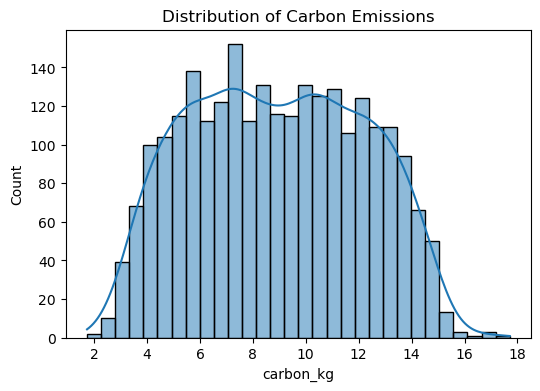

In [6]:
# Visualizations
# 1. Distribution of Carbon Emissions
plt.figure(figsize=(6,4))
sns.histplot(df['carbon_kg'], bins=30, kde=True)
plt.title("Distribution of Carbon Emissions")
plt.show()

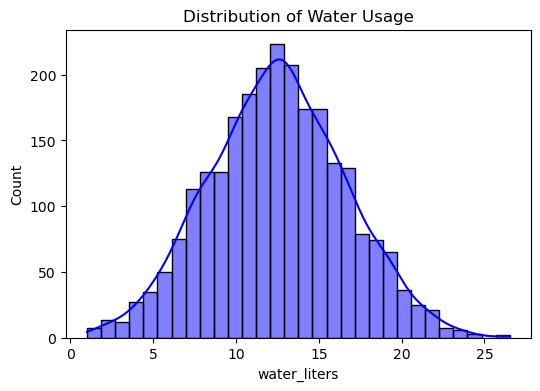

In [7]:
# 2. Distribution of Water Usage
plt.figure(figsize=(6,4))
sns.histplot(df['water_liters'], bins=30, kde=True, color='blue')
plt.title("Distribution of Water Usage")
plt.show()


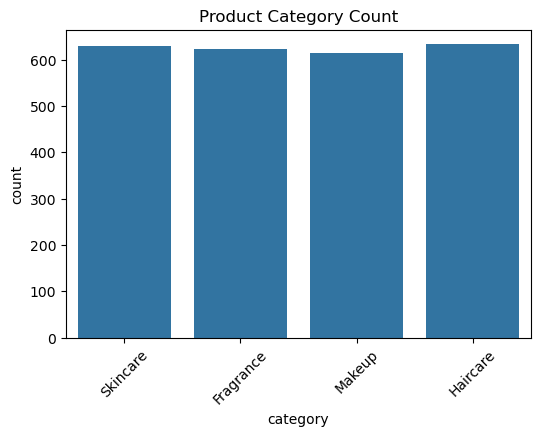

In [8]:
# 3. 

plt.figure(figsize=(6,4))
sns.countplot(x='category', data=df)
plt.title("Product Category Count")
plt.xticks(rotation=45)
plt.show()

#class imbalance/balance

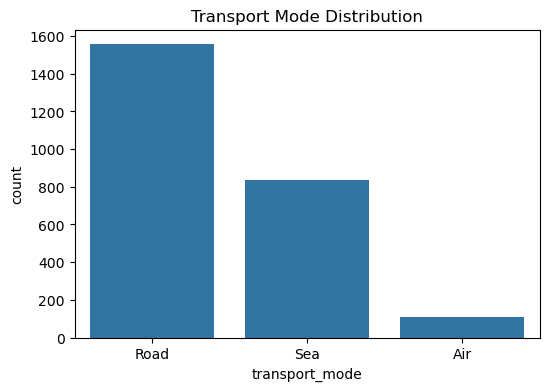

In [9]:
#4. 

plt.figure(figsize=(6,4))
sns.countplot(x='transport_mode', data=df)
plt.title("Transport Mode Distribution")
plt.show()

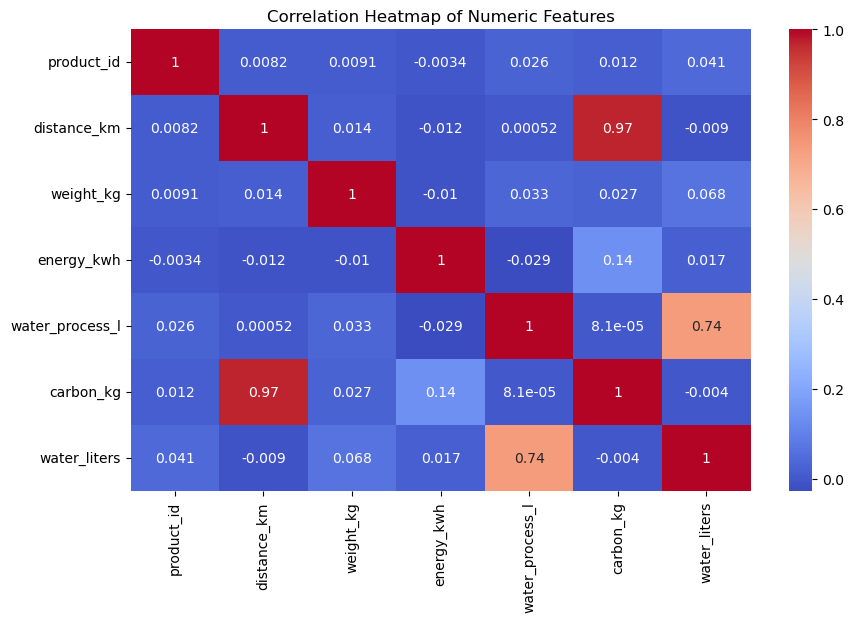

In [10]:
# 5. 
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()



In [27]:
# Preprocessing:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  

In [28]:
import pickle

# Save the fitted encoders for use in Streamlit
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [33]:
# --------------------- Train the RandomForest model ---------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

features = ['category', 'material', 'packaging_type', 'transport_mode',
            'distance_km', 'weight_kg', 'energy_kwh', 'water_process_l']

X = df[features]
y = df[['carbon_kg', 'water_liters']]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
# --- Train a MultiOutput Random Forest ---
base_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# --- Evaluate ---
y_pred = model.predict(X_test)

# Separate metrics for Carbon and Water
mae_carbon = mean_absolute_error(y_test['carbon_kg'], y_pred[:, 0])
mae_water  = mean_absolute_error(y_test['water_liters'], y_pred[:, 1])

rmse_carbon = np.sqrt(mean_squared_error(y_test['carbon_kg'], y_pred[:, 0]))
rmse_water  = np.sqrt(mean_squared_error(y_test['water_liters'], y_pred[:, 1]))

r2_carbon = r2_score(y_test['carbon_kg'], y_pred[:, 0])
r2_water  = r2_score(y_test['water_liters'], y_pred[:, 1])

print("Model Performance:")
print(f"Carbon  - MAE: {mae_carbon:.2f}, RMSE: {rmse_carbon:.2f}, R²: {r2_carbon:.2f}")
print(f"Water   - MAE: {mae_water:.2f}, RMSE: {rmse_water:.2f}, R²: {r2_water:.2f}")

Model Performance:
Carbon  - MAE: 0.35, RMSE: 0.44, R²: 0.98
Water   - MAE: 2.15, RMSE: 2.67, R²: 0.57


In [20]:
import pickle
with open("rf_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [19]:
import joblib
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

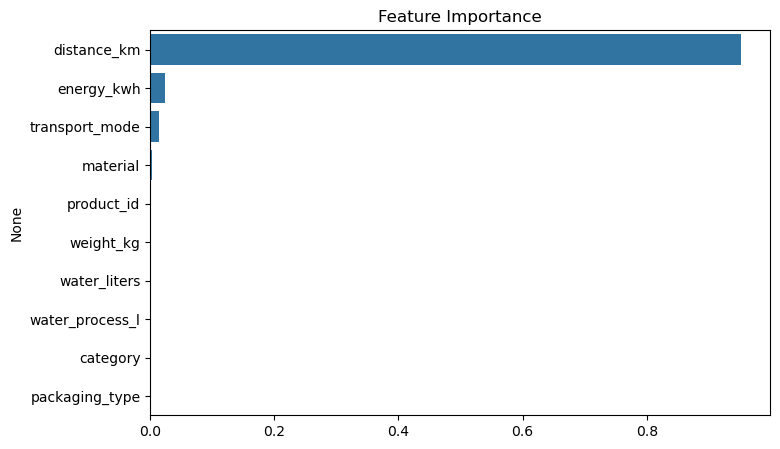

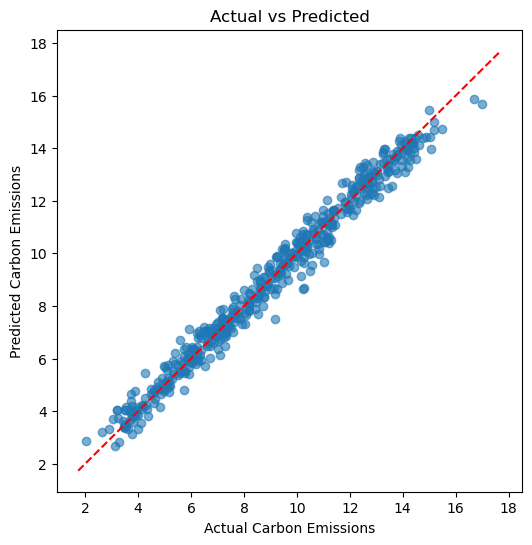

In [14]:
# --- Visualization: Feature importance ---

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importance")
plt.show()

# --- Visualization: Actual vs Predicted ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Carbon Emissions")
plt.ylabel("Predicted Carbon Emissions")
plt.title("Actual vs Predicted")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.show()

In [15]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R² Score:", r2_score(y_test, y_pred_xgb))

XGBoost Results:
MAE: 0.3010103404121399
RMSE: 0.38155147106252724
R² Score: 0.9864221592361708


In [16]:
import joblib

joblib.dump(model, "rf_model.pkl")      # Random Forest you trained first
joblib.dump(xgb_model, "xgb_model.pkl") # XGBoost you trained second

['xgb_model.pkl']

In [17]:
# Residual Plot (to check errors)
residuals = y_test - y_pred_rf

plt.figure(figsize=(8,6))
plt.scatter(y_pred_rf, residuals, alpha=0.6, color="purple")
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot - Random Forest")
plt.show()


NameError: name 'y_pred_rf' is not defined

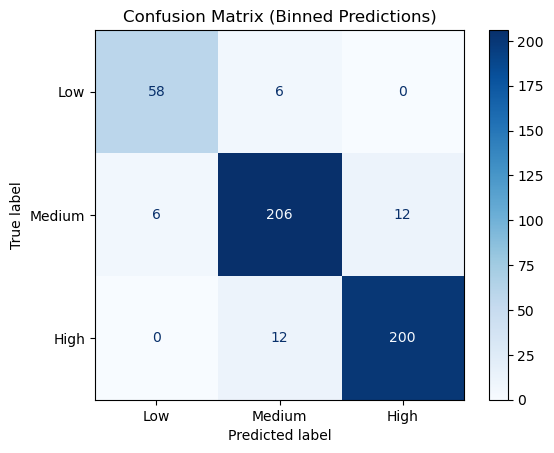

In [46]:
# Convert regression to risk classification
import numpy as np

# Example: Convert emissions into categories
bins = [0, 5, 10, 20]  # adjust based on your dataset
labels = ["Low", "Medium", "High"]
y_test_class = pd.cut(y_test, bins=bins, labels=labels)
y_pred_class = pd.cut(y_pred_rf, bins=bins, labels=labels)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_class, y_pred_class, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Binned Predictions)")
plt.show()

In [1]:
pip install streamlit pandas numpy scikit-learn joblib shap matplotlib plotly

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pickle
with open("label_encoders.pkl","rb") as f:
    enc = pickle.load(f)
print(type(enc), enc.keys())


<class 'dict'> dict_keys(['category', 'material', 'packaging_type', 'transport_mode'])


In [26]:
df.select_dtypes(include=['object']).columns



Index([], dtype='object')

In [32]:
print(X_train.columns)


Index(['category', 'material', 'packaging_type', 'transport_mode',
       'distance_km', 'weight_kg', 'energy_kwh', 'water_process_l'],
      dtype='object')


In [36]:
import pickle

with open("rf_model.pkl", "rb") as f:
    model = pickle.load(f)

# Check what feature names the model expects
try:
    print(model.estimators_[0].feature_names_in_)
except AttributeError:
    print("Cannot access feature names. Model might have been trained incorrectly.")


Cannot access feature names. Model might have been trained incorrectly.
